In [1]:
import os
os.environ["HF_TOKEN"] = "HF_INPUTE_YOUR_API"


In [2]:
!nvidia-smi


Fri Nov 14 18:14:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   44C    P0             57W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
!git clone https://github.com/Shenxuanyi-cmu/FederatedLLM
%cd FederatedLLM



Cloning into 'FederatedLLM'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 40 (delta 4), reused 39 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 40.80 MiB | 19.39 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/FederatedLLM


In [4]:
!sed -i '/bitsandbytes/d' requirements.txt
!sed -i '/jllllll\/bitsandbytes-wheels/d' requirements.txt

In [5]:
!pip install -r requirements.txt --upgrade --quiet

!pip install -U "transformers>=4.46.0" "accelerate>=1.0.0" "peft>=0.13.0" --quiet

!pip install -U "bitsandbytes>=0.45.0" --quiet

!python -m bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.2/510.2 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.5/508.5 kB 32.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Ignored the following yanked versions: 3.0.6, 3.5.0, 3.7.0, 3.17.0, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.0.4, 4.0.5, 4.0.7, 4.0.8, 4.0.9, 4.1.2, 4.1.6, 4.2.6, 4.2.7, 4.3.13, 4.3.16
ERROR: Could not find a version that satisfies the requirement conda==23.9.0 (from versions: none)
ERROR: No matching distribution found for conda==23.9.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 45.0 MB/s eta 0:00:00
=================== bitsandbytes v0.48.2 ===================
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
  libc: glibc-2.35
Python: 3.12.12
PyTorch: 2.8.0+cu126
  CUDA: 12.6
  HIP: N/A
  XPU: N/A
Related packages:
  accelerate: 1.11.0
  diffusers: 0.35.2
  

In [6]:
!pip install fire --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.9 MB/s eta 0:00:00


In [7]:
!pip install -U "transformers>=4.46.0" "peft>=0.17.0" "accelerate>=0.33.0" "bitsandbytes>=0.45.0"


In [8]:
%cd /content/FederatedLLM
!pwd
!ls data_wiz/10 | head

/content/FederatedLLM
/content/FederatedLLM
local_training_0.json
local_training_1.json
local_training_2.json
local_training_3.json
local_training_4.json
local_training_5.json
local_training_6.json
local_training_7.json
local_training_8.json
local_training_9.json


In [9]:
cutoff_len = 512
def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)
    result["labels"] = result["input_ids"].copy()
    return result

def generate_and_tokenize_prompt(data_point):
    if "context" in data_point:
        full_prompt = prompter.generate_prompt(
            data_point.get("instruction", ""),
            data_point.get("context", ""),
            data_point.get("response", data_point.get("output", "")),
        )
    else:
        full_prompt = prompter.generate_prompt(
            data_point.get("instruction", ""),
            data_point.get("input", ""),
            data_point.get("output", ""),
        )

    tokenized_full_prompt = tokenize(full_prompt)
    user_prompt = prompter.generate_prompt(
        data_point.get("instruction", ""),
        data_point.get("input", "")
    )
    tokenized_user_prompt = tokenize(user_prompt, add_eos_token=False)
    user_prompt_len = len(tokenized_user_prompt["input_ids"])
    tokenized_full_prompt["labels"] = (
        [-100] * user_prompt_len
        + tokenized_full_prompt["labels"][user_prompt_len:]
    )
    return tokenized_full_prompt

In [14]:
!rm -rf lora_sim_roberta_rte/*


Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧱 Training client 0 with 1218 samples ...


Step,Training Loss
20,0.255200
40,0.111900
60,0.166100
80,0.124700
100,0.108700
120,0.044600
140,0.189000


🧱 Training client 1 with 68 samples ...


Step,Training Loss


🧱 Training client 2 with 429 samples ...


Step,Training Loss
20,0.156200
40,0.002800


🧱 Training client 3 with 41 samples ...


Step,Training Loss


🧱 Training client 4 with 724 samples ...


Step,Training Loss
20,0.153600
40,0.032600
60,0.000700
80,0.036500


🧱 Training client 5 with 0 samples ...
⚠️ Client 5 has 0 samples — skipping.
🧱 Training client 6 with 0 samples ...
⚠️ Client 6 has 0 samples — skipping.
🧱 Training client 7 with 10 samples ...


Step,Training Loss


    layer         A         B
0       0  0.996134  0.220990
1       1  0.995385  0.293786
2       2  0.994641  0.344198
3       3  0.993981  0.320327
4       4  0.994827  0.321950
5       5  0.994467  0.312461
6       6  0.994948  0.272046
7       7  0.993883  0.298717
8       8  0.994442  0.223420
9       9  0.994314  0.282800
10     10  0.993918  0.242529
11     11  0.993415  0.219093


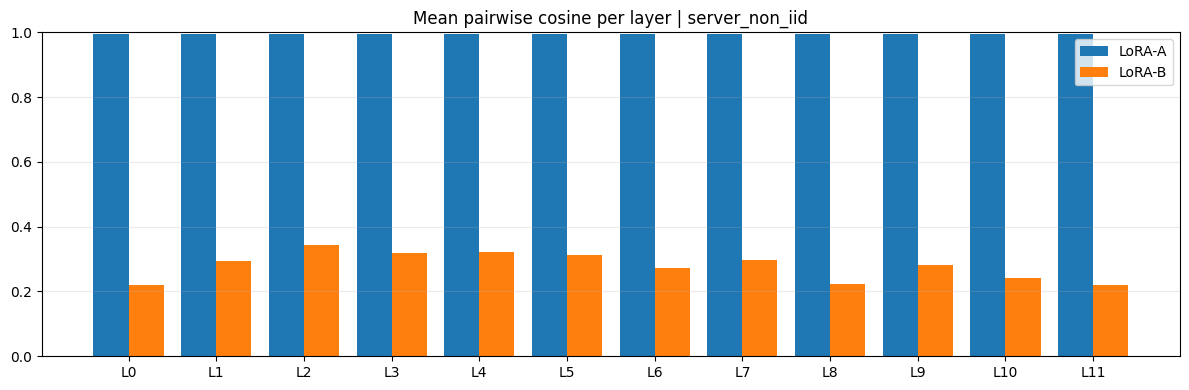

In [17]:

import os, math, copy, json, itertools, random, numpy as np, pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple
from tqdm import tqdm
import torch
import torch.nn.functional as F
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, DataCollatorWithPadding)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

@dataclass
class ExpCfg:
    model_name: str = "roberta-base"
    task_name: str = "rte"
    num_clients: int = 8
    local_epochs: int = 2
    per_device_batch: int = 16
    lr: float = 2e-4
    max_len: int = 256
    lora_r: int = 8
    lora_alpha: int = 16
    lora_dropout: float = 0.05
    target_modules: tuple = ("query", "value")
    hetero_mode: str = "iid"
    outdir: str = "./lora_sim_roberta_rte"

cfg = ExpCfg(
    num_clients=8,
    local_epochs=2,
    hetero_mode="server_non_iid",
)

os.makedirs(cfg.outdir, exist_ok=True)

raw = load_dataset("glue", cfg.task_name)
tok = AutoTokenizer.from_pretrained(cfg.model_name, use_fast=True)

def preprocess(batch):
    return tok(batch["sentence1"], batch["sentence2"], truncation=True, max_length=cfg.max_len)

encoded = raw.map(preprocess, batched=True)
num_labels = raw["train"].features["label"].num_classes

def split_clients(dataset, num_clients, mode="iid", dirichlet_alpha=0.5):
    labels = np.array(dataset["label"])
    n = len(labels)
    idxs = np.arange(n)

    if mode == "iid":
        np.random.shuffle(idxs)
        return np.array_split(idxs, num_clients)

    classes = np.unique(labels)
    class_indices = {c: np.where(labels == c)[0] for c in classes}
    parts = [[] for _ in range(num_clients)]
    alpha = dirichlet_alpha

    for c in classes:
        ci = class_indices[c]
        np.random.shuffle(ci)
        p = np.random.dirichlet([alpha] * num_clients)
        splits = (np.cumsum(p) * len(ci)).astype(int)[:-1]
        shards = np.split(ci, splits)
        for k in range(num_clients):
            parts[k].extend(shards[k].tolist())

    parts = [np.array(p, dtype=int) for p in parts]
    for k in range(num_clients):
        np.random.shuffle(parts[k])
    return parts


if cfg.hetero_mode == "iid":
    client_indices = split_clients(raw["train"], cfg.num_clients, "iid")

elif cfg.hetero_mode == "moderate_non_iid":
    client_indices = split_clients(raw["train"], cfg.num_clients, "dir", dirichlet_alpha=0.5)

elif cfg.hetero_mode == "server_non_iid":
    client_indices = split_clients(raw["train"], cfg.num_clients, "dir", dirichlet_alpha=0.1)

else:
    raise ValueError("hetero_mode must be ['iid','moderate_non_iid','server_non_iid']")

cols_to_keep = ["input_ids", "attention_mask", "label"]

def make_subset(ds, indices):
    return ds.select(indices).remove_columns([c for c in ds.column_names if c not in cols_to_keep])

client_datasets = [make_subset(encoded["train"], idxs) for idxs in client_indices]
eval_ds = make_subset(encoded["validation"], range(len(encoded["validation"])))

quant_ok = torch.cuda.is_available()
base_model = AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=num_labels)

base_model = prepare_model_for_kbit_training(base_model)
lora_cfg = LoraConfig(
    r=cfg.lora_r, lora_alpha=cfg.lora_alpha, lora_dropout=cfg.lora_dropout,
    target_modules=list(cfg.target_modules), bias="none", task_type="SEQ_CLS"
)
base_model = get_peft_model(base_model, lora_cfg)

def train_one_client(client_id, train_ds):
    if len(train_ds) == 0:
        print(f" Client {client_id} has 0 samples — skipping.")
        return None

    model = copy.deepcopy(base_model)
    args = TrainingArguments(
        output_dir=os.path.join(cfg.outdir, f"client_{client_id}"),
        num_train_epochs=cfg.local_epochs,
        per_device_train_batch_size=cfg.per_device_batch,
        per_device_eval_batch_size=cfg.per_device_batch,
        learning_rate=cfg.lr,
        logging_steps=20,
        eval_strategy="no",
        save_strategy="no",
        report_to=[],
        seed=SEED,
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        data_collator=DataCollatorWithPadding(tok),
    )
    trainer.train()
    return model

client_models = []
for k in range(cfg.num_clients):
    print(f" Training client {k} with {len(client_datasets[k])} samples ...")
    m = train_one_client(k, client_datasets[k])
    if m is not None:
        client_models.append(m)

def extract_lora_by_layer(model) -> Dict[str, Dict[int, torch.Tensor]]:
    A_layers, B_layers = {}, {}
    for n, p in model.named_parameters():
        if "lora_A" in n or "lora_B" in n:
            parts = n.split(".")
            if "layer" not in parts:
                continue
            lid = int(parts[parts.index("layer")+1])
            if "attention" not in parts or not any(t in parts for t in ["query","value"]):
                continue
            key = "A" if "lora_A" in n else "B"
            vec = p.detach().cpu().flatten()
            (A_layers if key=="A" else B_layers).setdefault(lid, []).append(vec)
    return {
        "A": {lid: torch.cat(vs) for lid, vs in A_layers.items()},
        "B": {lid: torch.cat(vs) for lid, vs in B_layers.items()}
    }

client_loras = [extract_lora_by_layer(m) for m in client_models]
all_layers = sorted(set().union(*[set(d["A"].keys()) for d in client_loras]))

def mean_pairwise_cosine(vectors):
    if len(vectors) < 2: return float("nan")
    sims = []
    for i,j in itertools.combinations(range(len(vectors)),2):
        sims.append(F.cosine_similarity(vectors[i].unsqueeze(0), vectors[j].unsqueeze(0)).item())
    return float(np.mean(sims))

layer_stats = []
for lid in all_layers:
    A_vecs, B_vecs = [], []
    for c in range(len(client_loras)):
        if lid in client_loras[c]["A"]: A_vecs.append(client_loras[c]["A"][lid])
        if lid in client_loras[c]["B"]: B_vecs.append(client_loras[c]["B"][lid])
    layer_stats.append({
        "layer": lid,
        "A": mean_pairwise_cosine(A_vecs),
        "B": mean_pairwise_cosine(B_vecs),
    })

df = pd.DataFrame(layer_stats).sort_values("layer")
df.to_csv(os.path.join(cfg.outdir, f"pairwise_cosine_{cfg.hetero_mode}.csv"), index=False)
print(df)

plt.figure(figsize=(12,4))
x = np.arange(len(df))
plt.bar(x-0.2, df["A"], width=0.4, label="LoRA-A")
plt.bar(x+0.2, df["B"], width=0.4, label="LoRA-B")
plt.xticks(x, [f"L{int(l)}" for l in df["layer"]], rotation=0)
plt.ylim(0,1.0); plt.grid(axis="y", alpha=0.25)
plt.title(f"Mean pairwise cosine per layer | {cfg.hetero_mode}")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(cfg.outdir, f"figure2_style_{cfg.hetero_mode}.png"))
plt.show()


In [21]:
for name, _ in client_models[0].named_parameters():
    if "lora" in name.lower():
        print(name)

base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.value.lora_B.default

In [24]:
def show_lora_matrix(model, layer_id, module="query", AB="A"):
    """
    model:  client_models[k]
    layer_id: int, [0-11]
    module: "query" or "value"
    AB: "A" or "B"
    """

    target = (
        f"base_model.model.roberta.encoder.layer.{layer_id}"
        f".attention.self.{module}.lora_{AB}.default.weight"
    )

    for name, param in model.named_parameters():
        if name == target:
            print(f" Found LoRA-{AB}: {name}")
            print("Shape:", param.shape)
            print("Values:")
            print(param.detach().cpu().numpy())
            return param.detach().cpu()

    print(f" Not found: {target}")
    print("\n Available LoRA parameters include:")
    for name, _ in model.named_parameters():
        if "lora_" in name:
            print(name)

    return None

#show_lora_matrix(client_models[0], layer_id=3, module="query", AB="B")


✔ Found LoRA-B: base_model.model.roberta.encoder.layer.3.attention.self.query.lora_B.default.weight
Shape: torch.Size([768, 8])
Values:
[[ 2.8292751e-03 -9.7573975e-05  9.6176530e-04 ...  1.4129642e-03
  -1.1296031e-03  1.0253303e-03]
 [-4.7945976e-04  3.5845004e-03 -8.2511501e-04 ...  6.9458911e-04
   1.0743752e-03 -7.4610213e-04]
 [ 1.2248683e-03 -9.8120852e-04  8.5054926e-04 ...  2.5186748e-03
  -2.2178395e-03  1.3236156e-03]
 ...
 [-1.7793538e-03  4.0558688e-03  1.2541711e-03 ...  8.7239727e-04
   1.0005356e-03  9.8281249e-04]
 [-1.4681758e-03  3.1492298e-06 -2.0216133e-03 ... -1.9872915e-03
   3.6490557e-03 -4.5260967e-05]
 [-7.8870717e-04  4.6477618e-04 -5.3489380e-06 ... -1.4880947e-04
   3.2552256e-04  9.3381846e-04]]
✔ Found LoRA-B: base_model.model.roberta.encoder.layer.3.attention.self.query.lora_B.default.weight
Shape: torch.Size([768, 8])
Values:
[[ 1.06600448e-04 -3.87340871e-04 -8.93647593e-05 ... -2.88129610e-04
   3.40560102e-04  2.99337771e-05]
 [-2.89555930e-04  2.34

tensor([[ 1.0660e-04, -3.8734e-04, -8.9365e-05,  ..., -2.8813e-04,
          3.4056e-04,  2.9934e-05],
        [-2.8956e-04,  2.3484e-04, -1.6494e-04,  ...,  1.7592e-04,
          1.9119e-04, -1.4323e-04],
        [ 3.1296e-05, -1.8406e-05, -2.2581e-04,  ...,  2.4163e-04,
          9.0735e-05, -1.1497e-04],
        ...,
        [-4.1190e-04,  9.1118e-04, -2.5785e-04,  ..., -4.5222e-04,
          2.1481e-05, -5.7073e-04],
        [-1.4034e-04, -5.0209e-04, -7.8020e-04,  ..., -6.5972e-04,
          3.4619e-04, -5.7054e-04],
        [ 9.3091e-04,  6.7736e-05,  2.3486e-04,  ...,  9.0268e-04,
         -1.7090e-04,  3.7678e-04]])

In [ ]:
%cd /content/FederatedLLM

!python main.py --mode full_sa \
    --num_communication_rounds 3 \
    --output_dir ./runs/warmup

/content/FederatedLLM
2025-11-14 18:16:55.432612: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 18:16:55.450283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763144215.471431    3426 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763144215.477876    3426 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763144215.494836    3426 computation_placer.cc:177] computation placer already registered. Please check link